In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
strategy = tf.distribute.MirroredStrategy()

2025-06-18 10:38:31.686621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750243111.902463      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750243111.960399      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1750243126.430989      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Masking, Conv1D, BatchNormalization, Dropout, MaxPooling1D, LSTM, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

In [3]:
def load_ensemble(save_paths):
    models = []
    for save_path in save_paths:
        models.append(load_model(save_path))
    return models

def predict(X, models):
    predictions = []
    for model in models:
        predictions.append(model.predict(X))
    return np.mean(predictions, axis=0)

In [4]:
X_test = np.load('/kaggle/input/ml-tw-parkinsons-feature-selection/X_test.npy')
y_test = np.load('/kaggle/input/ml-tw-parkinsons-feature-selection/y_test.npy')

In [5]:
models_folder = '/kaggle/input/ml-tw-parkinsons-feature-selection/best_models/'
model_paths = [models_folder + model_path for model_path in os.listdir(models_folder)]
models = load_ensemble(model_paths)

In [6]:
with open('/kaggle/input/ml-tw-parkinsons-feature-selection/features_indices.txt','r') as f:
    features = list(map(int, f.readline().split()))

In [7]:
y_pred = predict(X_test[:,:,features],models)

I0000 00:00:1750243129.835365      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


In [8]:
positive_ratio = y_test.mean()
cm = confusion_matrix(y_test, y_pred>0.5)
tn, fp, fn, tp = cm.ravel()
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred>0.5)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
O2 = 1 - recall
O1 = positive_ratio * recall * (1/precision - 1)

df = pd.DataFrame([{'accuracy' : accuracy,
                   'precision' : precision,
                   'recall' : recall,
                   'specificity': specificity,
                   'O1' : O1,
                   'O2' : O2,
                   'roc-auc' : roc_auc}]).T
df.columns = ['value']
df

,value
accuracy,0.700000
precision,0.750000
recall,0.705882
specificity,0.692308
O1,0.133333
O2,0.294118
roc-auc,0.800905


<Figure size 1000x700 with 0 Axes>

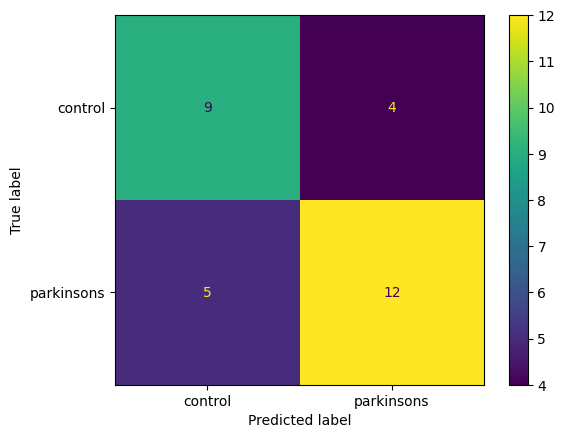

In [9]:
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['control','parkinsons'])

plt.figure(figsize=(10,7))
cm_plot.plot()
plt.show()

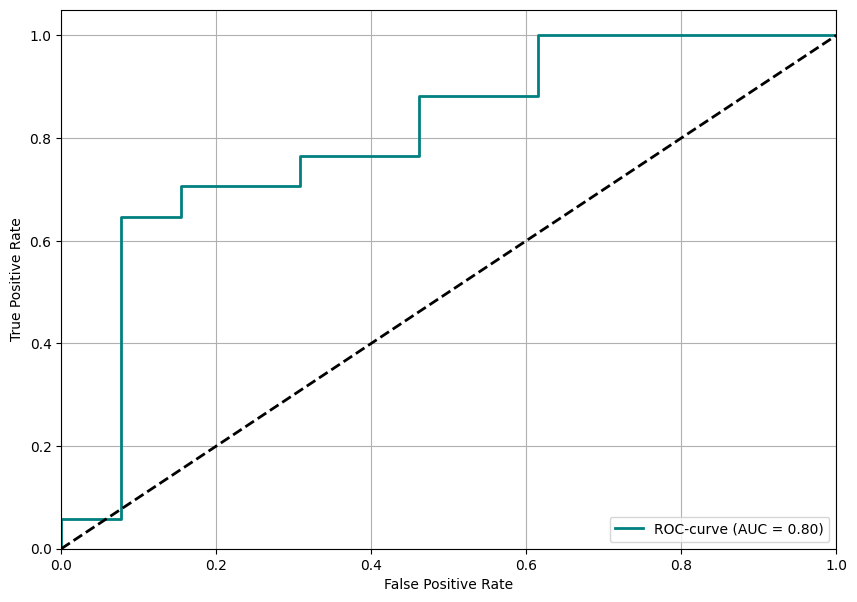

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='teal', lw=2, label=f'ROC-curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()